In [237]:
# Import Core Packages
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
import pandas as pd
import re
import sys
import os
from pathlib import Path
import platform
import shutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
basepath = Path(r'E:\Data\PCDisruption\Strawberry\Stb_2024-10-27_LeMans')
# Get current OS and set paths dependent on working OS.
cur_system = platform.system()
cur_dir = Path(os.getcwd())

if cur_system == "Linux":  # For Linux
    sys.path.extend(['/home/kimqi/Documents/Repositories/NeuroPy'])  # NeuroPy Path
    # Directories
    basepath = Path('/media/kimqi/BK/Data/PCDisruption/Raw/Strawberry/Stb_2024-10-27_LeMans')
    save_dir = Path('/home/kimqi/Documents/Analyses')
    sess_folder = Path('/media/kimqi/BK/Data/PCDisruption/Raw/Strawberry/Stb_2024-10-27_LeMans/2024-10-27_12-58-28/Record Node 104')
    event_dir = Path(r'/media/kimqi/BK/Data/PCDisruption/Raw/Strawberry/Stb_2024-10-27_LeMans/2024-10-27_12-58-28/Record Node 104/experiment1/recording1/events/RHD_Rec_Controller-100.Rhythm Data/TTL')

elif cur_system == "Windows":
    sys.path.extend([r'E:\Code\Repositories\NeuroPy'])  # NeuroPy Path

    # Data Directories
    cur_folder = Path(basepath).name
    save_dir = Path('E:\Analyses\Preliminary')
    sess_folder = Path(r"E:\Data\PCDisruption\Strawberry\Stb_2024-10-27_LeMans\2024-10-27_12-58-28\Record Node 104")
    event_dir = Path(r"E:\Data\PCDisruption\Strawberry\Stb_2024-10-27_LeMans\2024-10-27_12-58-28\Record Node 104\experiment1\recording1\events\RHD_Rec_Controller-100.Rhythm Data\TTL")

animal = basepath.parent.name
session_name = re.sub(r'_\d{4}-\d{2}-\d{2}_', '_', cur_folder)

save_dir = Path(save_dir / animal / cur_folder)
plot_dir = Path(save_dir / 'Plots')


save_dir.mkdir(parents=True, exist_ok=True)
plot_dir.mkdir(parents=True, exist_ok=True)

print(basepath)
print(cur_folder)
print(session_name)
print(save_dir)
print(plot_dir)
print(sess_folder)
print(event_dir)

/media/kimqi/BK/Data/PCDisruption/Raw/Strawberry/Stb_2024-10-27_LeMans
Stb_2024-10-27_LeMans
Stb_LeMans
/home/kimqi/Documents/Analyses/Strawberry/Stb_2024-10-27_LeMans
/home/kimqi/Documents/Analyses/Strawberry/Stb_2024-10-27_LeMans/Plots
/media/kimqi/BK/Data/PCDisruption/Raw/Strawberry/Stb_2024-10-27_LeMans/2024-10-27_12-58-28/Record Node 104
/media/kimqi/BK/Data/PCDisruption/Raw/Strawberry/Stb_2024-10-27_LeMans/2024-10-27_12-58-28/Record Node 104/experiment1/recording1/events/RHD_Rec_Controller-100.Rhythm Data/TTL


In [305]:
# Import NeuroPy Packages

# Analyses
from neuropy.analyses import oscillations
from neuropy.analyses.spkepochs import detect_pbe_epochs
from neuropy.analyses import placefields

# Core
from neuropy import core

from neuropy.core import Epoch
from neuropy.core import Neurons
from neuropy.core import Position
from neuropy.core.neurons import binned_pe_raster
from neuropy.core.neurons import pe_raster

from neuropy.core import BinnedSpiketrain
from neuropy.core import Shank, Probe, ProbeGroup

from neuropy.core.session import ProcessData

# IO
from neuropy.io import PhyIO

from neuropy.io.binarysignalio import BinarysignalIO
from neuropy.io.openephysio import get_dat_timestamps
from neuropy.io.openephysio import load_all_ttl_events

# Plotting
from neuropy.plotting import plot_probe
from neuropy.plotting import Fig
from neuropy.plotting import spikes
from neuropy.plotting.ratemaps import plot_ratemap

from neuropy.plotting.signals import plot_signal_traces

# Utils

from neuropy.utils import neurons_util
from neuropy.utils.ccg import correlograms
from neuropy.utils.mathutil import contiguous_regions
from neuropy.utils.signal_process import filter_sig
from neuropy.utils import position_util

import neuropy.io.optitrackio as optiio
import neuropy.io.openephysio as oeio

In [21]:
settings_path = oeio.get_settings_file(sess_folder)
print(settings_path)
rec_df = oeio.create_sync_df(sess_folder)
rec_df

/media/kimqi/BK/Data/PCDisruption/Raw/Strawberry/Stb_2024-10-27_LeMans/2024-10-27_12-58-28/Record Node 104/settings.xml
start time = 2024-10-27 12:58:28.836000-04:00
start time = 2024-10-27 13:04:07.234000-04:00
start time = 2024-10-27 13:08:56.940000-04:00
start time = 2024-10-27 13:50:37.149000-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2024-10-27 12:58:28.836000-04:00,start,0,0.000000,0,0.0000
1,0,2024-10-27 13:04:06.918100-04:00,stop,10142463,338.082100,422602,338.0816
2,1,2024-10-27 13:04:07.234000-04:00,start,10142464,338.082133,422603,338.0824
3,1,2024-10-27 13:08:53.476100-04:00,stop,18729727,624.324233,780405,624.3240
4,2,2024-10-27 13:08:56.940000-04:00,start,18729728,624.324267,780406,624.3248
5,2,2024-10-27 13:50:36.822633333-04:00,stop,93726207,3124.206900,3905258,3124.2064
6,3,2024-10-27 13:50:37.149000-04:00,start,93726208,3124.206933,3905259,3124.2072
7,3,2024-10-27 13:52:40.711633333-04:00,stop,97433087,3247.769567,4059711,3247.7688


In [22]:
#rec_start = rec_df.loc[4, "Datetime"]
opti_obj = optiio.OptitrackIO(basepath) # Load in optitrack position data from .csv
opti_obj.datetime_array = opti_obj.datetime_array.tz_localize("America/Detroit")
ttl_dict = oeio.load_ttl_events(event_dir)  # Load in TTL data
ttl_dict['start_time']

/media/kimqi/BK/Data/PCDisruption/Raw/Strawberry/Stb_2024-10-27_LeMans/Stb_2024-10-27_LeMans.csv


datetime.datetime(2024, 10, 27, 12, 58, 28, 836000, tzinfo=tzfile('/usr/share/zoneinfo/America/Detroit'))

In [23]:
start_datetime = rec_df.loc[2, 'Datetime']
t_start = rec_df.loc[2, 'dat_time']
t_stop = rec_df.loc[5, 'dat_time']
print(start_datetime)
print(t_start)
print(t_stop)

2024-10-27 13:04:07.234000-04:00
338.08213333333333
3124.2069


In [24]:
motive_ttl_channel = 2
motive_start_frame = ttl_dict["timestamps"][np.where(ttl_dict["channel_states"] == motive_ttl_channel)[0][0]]
motive_start_datetime = ttl_dict['start_time'] + pd.to_timedelta(motive_start_frame / ttl_dict["SR"], unit="sec")
print(motive_start_datetime)

2024-10-27 13:04:02.579633-04:00


In [26]:
opti_obj.remove_negatives(ref_time=start_datetime)

In [27]:
# Now subtract to get absolute time passed in seconds from recording start
motive_times_from_oe_rec_start = (opti_obj.datetime_array - start_datetime).total_seconds()
motive_times_from_oe_rec_start

Float64Index([   0.016667,        0.05,    0.083333,    0.116667,        0.15,
                 0.183333,    0.216667,        0.25,    0.283333,    0.316667,
              ...
              2793.883333, 2793.916667,     2793.95, 2793.983333, 2794.016667,
                  2794.05, 2794.083333, 2794.116667,     2794.15, 2794.183333],
             dtype='float64', length=83826)

In [28]:
#print(opti_obj.datetime_array)
print(len(opti_obj.datetime_array))
print(opti_obj.datetime_starts)
print(opti_obj.datetime_stops)
print(opti_obj.datetime_nframes)

83826
2024-10-27 13:04:07.250667-04:00
2024-10-27 13:50:41.417333-04:00
83826


In [29]:
sess = ProcessData(basepath)
phy_dir = sorted(sess.basepath.glob("**/params.py"))[0].parent
sess.phy = PhyIO(dirname=phy_dir)
sess.neurons = Neurons(sess.phy.spiketrains, t_stop=sess.eegfile.duration, neuron_ids=sess.phy.neuron_ids,
                       neuron_type=sess.phy.cluster_info["group"], waveforms=sess.phy.waveforms, 
                       waveforms_amplitude=sess.phy.waveforms_amplitude, sampling_rate=sess.recinfo.dat_sampling_rate,
                       peak_channels=sess.phy.peak_channels, clu_q=sess.phy.clu_q, shank_ids=sess.phy.shank_ids)

id column does not exist in cluster_info.tsv. Using cluster_id column instead.


In [148]:
pfs = sess.neurons.time_slice(t_start=t_start, t_stop=t_stop, zero_spike_times=True)
motive_sr = 30
pos2d = np.array([opti_obj.x, opti_obj.z]) # create a 2 x nframes array of x/y positions 

pos = Position(traces=pos2d, t_start=0, sampling_rate=motive_sr)
pos = position_util.linearize_position(pos)

/home/kimqi/.conda/envs/NeuroPy/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/kimqi/.conda/envs/NeuroPy/lib/python3.11/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


In [279]:
print(pos.duration)
print(max(motive_times_from_oe_rec_start))

2794.2
2794.183333
2786.124766666667


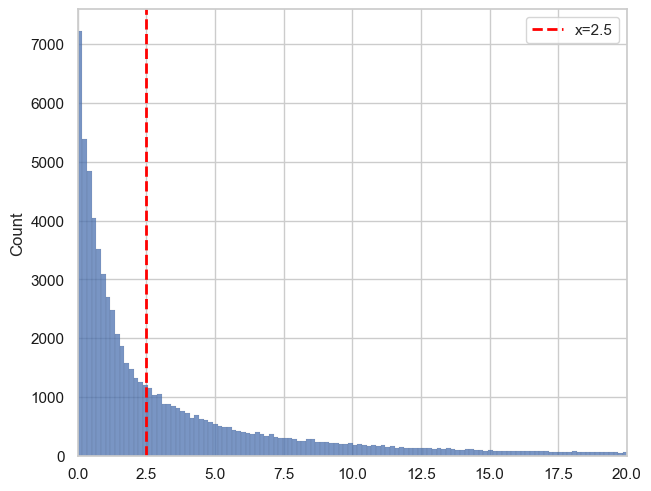

In [250]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example data (replace 'test_place_cells.speed' with your actual data)
speed_data = test_place_cells.speed  # Replace this with your actual data

# Plot histogram using seaborn
sns.histplot(speed_data, bins=1000, kde=False, edgecolor="black")

# Draw vertical line at x=3
plt.axvline(x=2.5, color='red', linestyle='--', linewidth=2, label='x=2.5')

# Set x-axis limits
plt.xlim(0, 20)

# Add legend for clarity
plt.legend()

# Show the plot
plt.show()

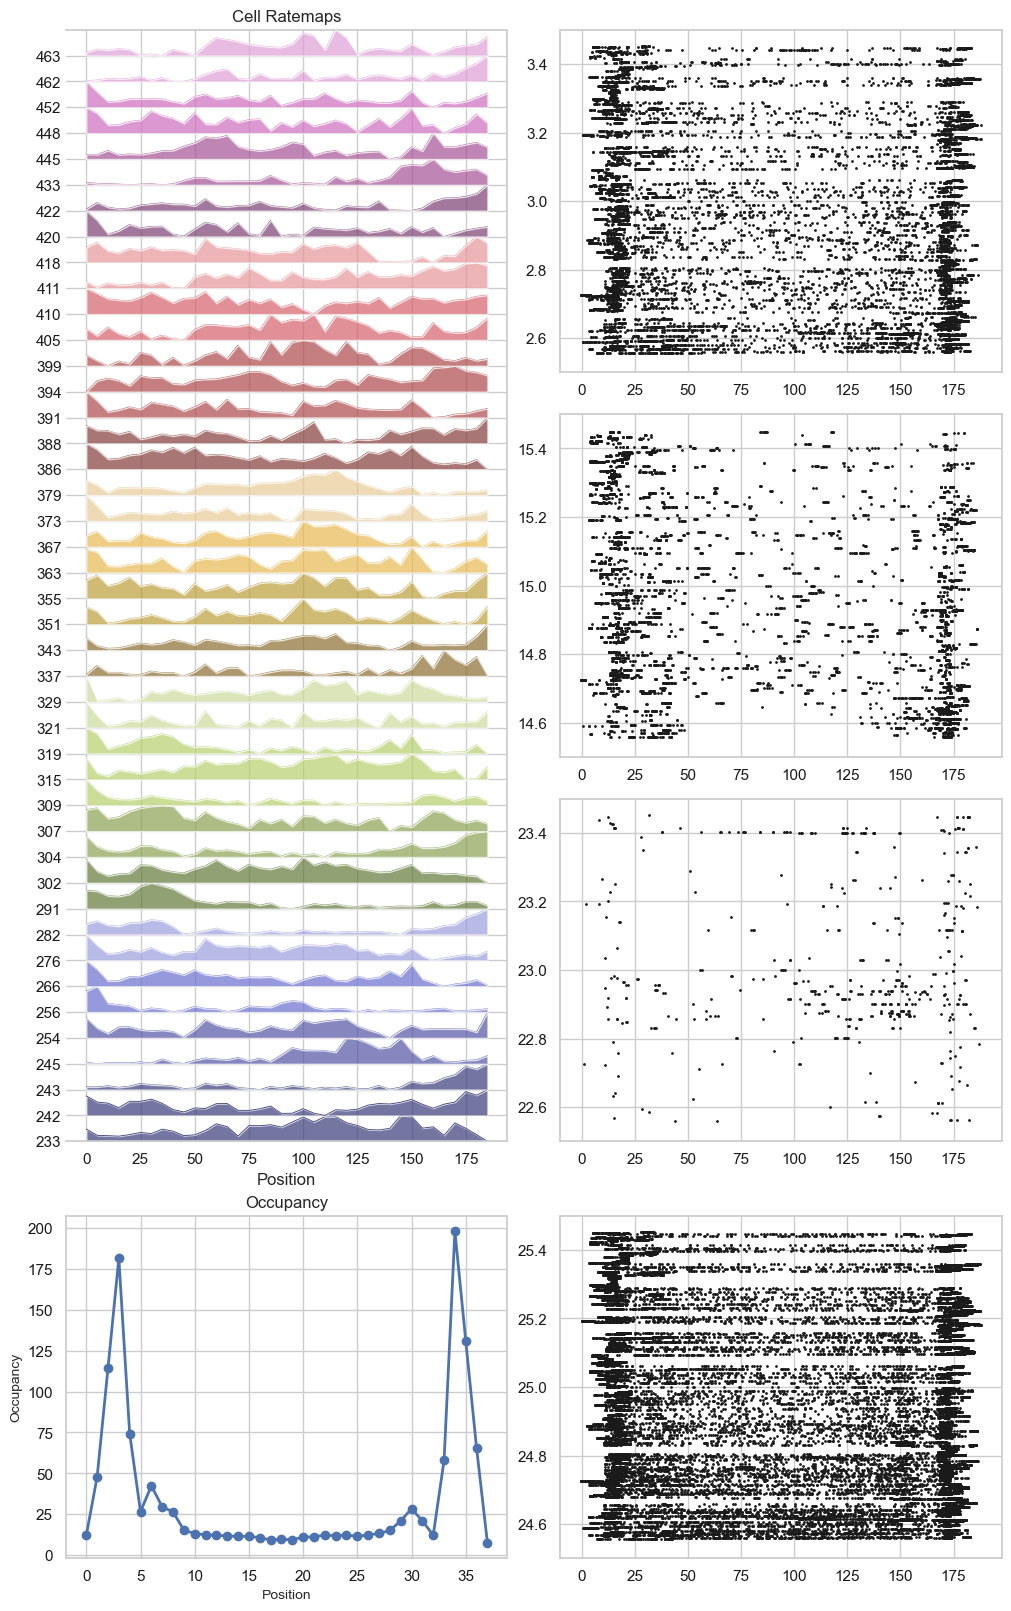

In [280]:
test_place_cells = placefields.Pf1D(neurons=pfs, position=pos, speed_thresh=2.5)


fig = plt.figure(figsize=(10, 16))
gs = gridspec.GridSpec(4, 2, figure=fig)

# Create an axes that spans 2 rows in the first column
ax1 = fig.add_subplot(gs[0:3, 0])  # This spans all rows in the first column
ax2 = fig.add_subplot(gs[3, 0])  # Top-right
ax3 = fig.add_subplot(gs[0, 1])  # Bottom-right
ax4 = fig.add_subplot(gs[1, 1])  # Bottom-right
ax5 = fig.add_subplot(gs[2, 1])  # Bottom-right
ax6 = fig.add_subplot(gs[3, 1])  # Bottom-right


ax1.set_title('Cell Ratemaps')
plot_ratemap(test_place_cells, ax=ax1, normalize_tuning_curve=True, sortby=True)

ax2.plot(test_place_cells.occupancy, marker='o', linestyle='-', linewidth=2)
ax2.set_title("Occupancy", fontsize=12)
ax2.set_xlabel("Position", fontsize=10)
ax2.set_ylabel("Occupancy", fontsize=10)

sns.set_theme(style="whitegrid")

test_place_cells.plot_ratemaps_raster(ax=ax3,plot_time=True)
ax3.set_ylim([2.5, 3.5])

test_place_cells.plot_ratemaps_raster(ax=ax4,plot_time=True)
ax4.set_ylim([14.5, 15.5])

test_place_cells.plot_ratemaps_raster(ax=ax5,plot_time=True)
ax5.set_ylim([22.5, 23.5])

test_place_cells.plot_ratemaps_raster(ax=ax6,plot_time=True)
ax6.set_ylim([24.5, 25.5])

plt.show()

In [284]:
opto_epoch = [0, stim_epochs_df['stop'].max() -t_start + filtered_values.median()]
ctrl_epoch = [stim_epochs_df['stop'].max() - t_start + filtered_values.median(), max(motive_times_from_oe_rec_start)]
#opto_epoch = opto_epoch - t_start
#ctrl_epoch = ctrl_epoch - t_start

print(opto_epoch)
print(ctrl_epoch)

[0, 1057.8402500000002]
[1057.8402500000002, 2794.183333]


In [285]:
opto_cells = sess.neurons.time_slice(t_start=opto_epoch[0], t_stop=opto_epoch[1], zero_spike_times=True)
ctrl_cells = sess.neurons.time_slice(t_start=ctrl_epoch[0], t_stop=ctrl_epoch[1], zero_spike_times=True)

motive_sr = 30
pos2d = np.array([opti_obj.x, opti_obj.z]) # create a 2 x nframes array of x/y positions 

pos = Position(traces=pos2d, t_start=0, sampling_rate=motive_sr)
pos = position_util.linearize_position(pos)

/home/kimqi/.conda/envs/NeuroPy/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/kimqi/.conda/envs/NeuroPy/lib/python3.11/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


In [317]:
opto_pos = pos.time_slice(t_start=opto_epoch[0], t_stop=opto_epoch[1])
ctrl_pos = pos.time_slice(t_start=ctrl_epoch[0], t_stop=ctrl_epoch[1],zero_times=True)

In [318]:
opto_pfs = placefields.Pf1D(neurons=opto_cells, position=opto_pos, speed_thresh=2.5)
ctrl_pfs = placefields.Pf1D(neurons=ctrl_cells, position=ctrl_pos, speed_thresh=2.5)

(32.5, 33.5)

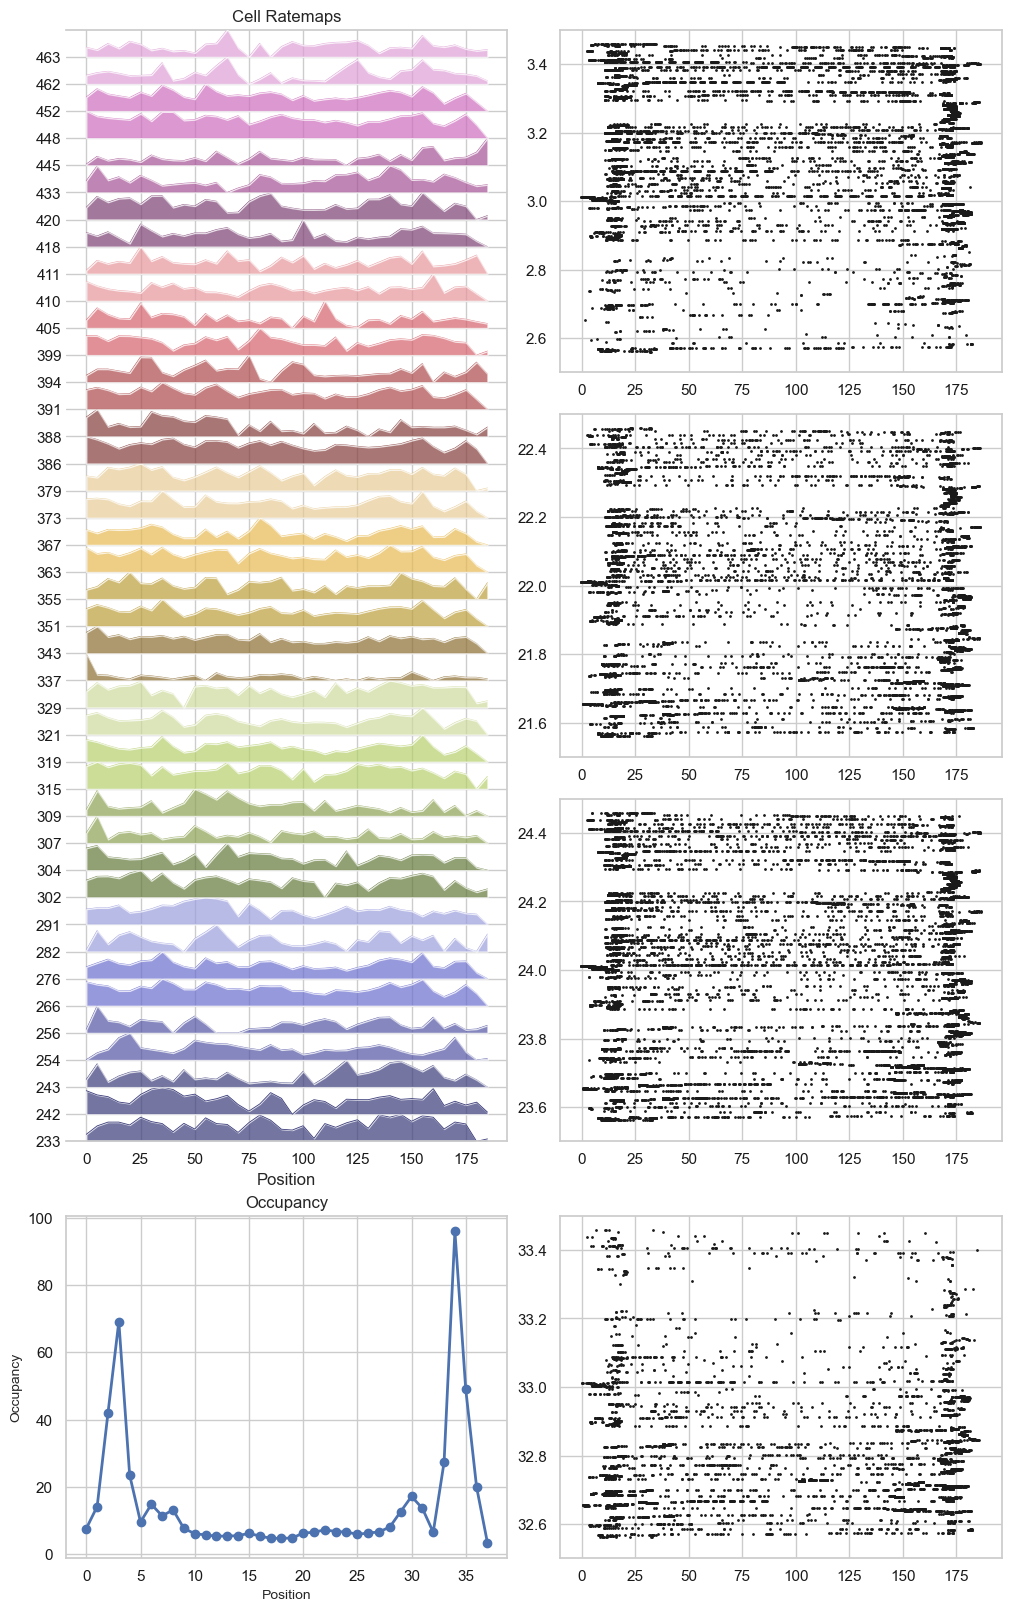

In [319]:
# Opto Condition Place Fields
fig = plt.figure(figsize=(10, 16))
gs = gridspec.GridSpec(4, 2, figure=fig)

# Create an axes that spans 2 rows in the first column
ax1 = fig.add_subplot(gs[0:3, 0])  # This spans all rows in the first column
ax2 = fig.add_subplot(gs[3, 0])  # Top-right
ax3 = fig.add_subplot(gs[0, 1])  # Bottom-right
ax4 = fig.add_subplot(gs[1, 1])  # Bottom-right
ax5 = fig.add_subplot(gs[2, 1])  # Bottom-right
ax6 = fig.add_subplot(gs[3, 1])  # Bottom-right


ax1.set_title('Cell Ratemaps')
plot_ratemap(opto_pfs, ax=ax1, normalize_tuning_curve=True, sortby=False)

ax2.plot(opto_pfs.occupancy, marker='o', linestyle='-', linewidth=2)
ax2.set_title("Occupancy", fontsize=12)
ax2.set_xlabel("Position", fontsize=10)
ax2.set_ylabel("Occupancy", fontsize=10)

sns.set_theme(style="whitegrid")

opto_pfs.plot_ratemaps_raster(ax=ax3,plot_time=True,sort=False)
ax3.set_ylim([2.5, 3.5])

opto_pfs.plot_ratemaps_raster(ax=ax4,plot_time=True,sort=False)
ax4.set_ylim([21.5, 22.5])

opto_pfs.plot_ratemaps_raster(ax=ax5,plot_time=True,sort=False)
ax5.set_ylim([23.5, 24.5])

opto_pfs.plot_ratemaps_raster(ax=ax6,plot_time=True,sort=False)
ax6.set_ylim([32.5, 33.5])

(34.5, 35.5)

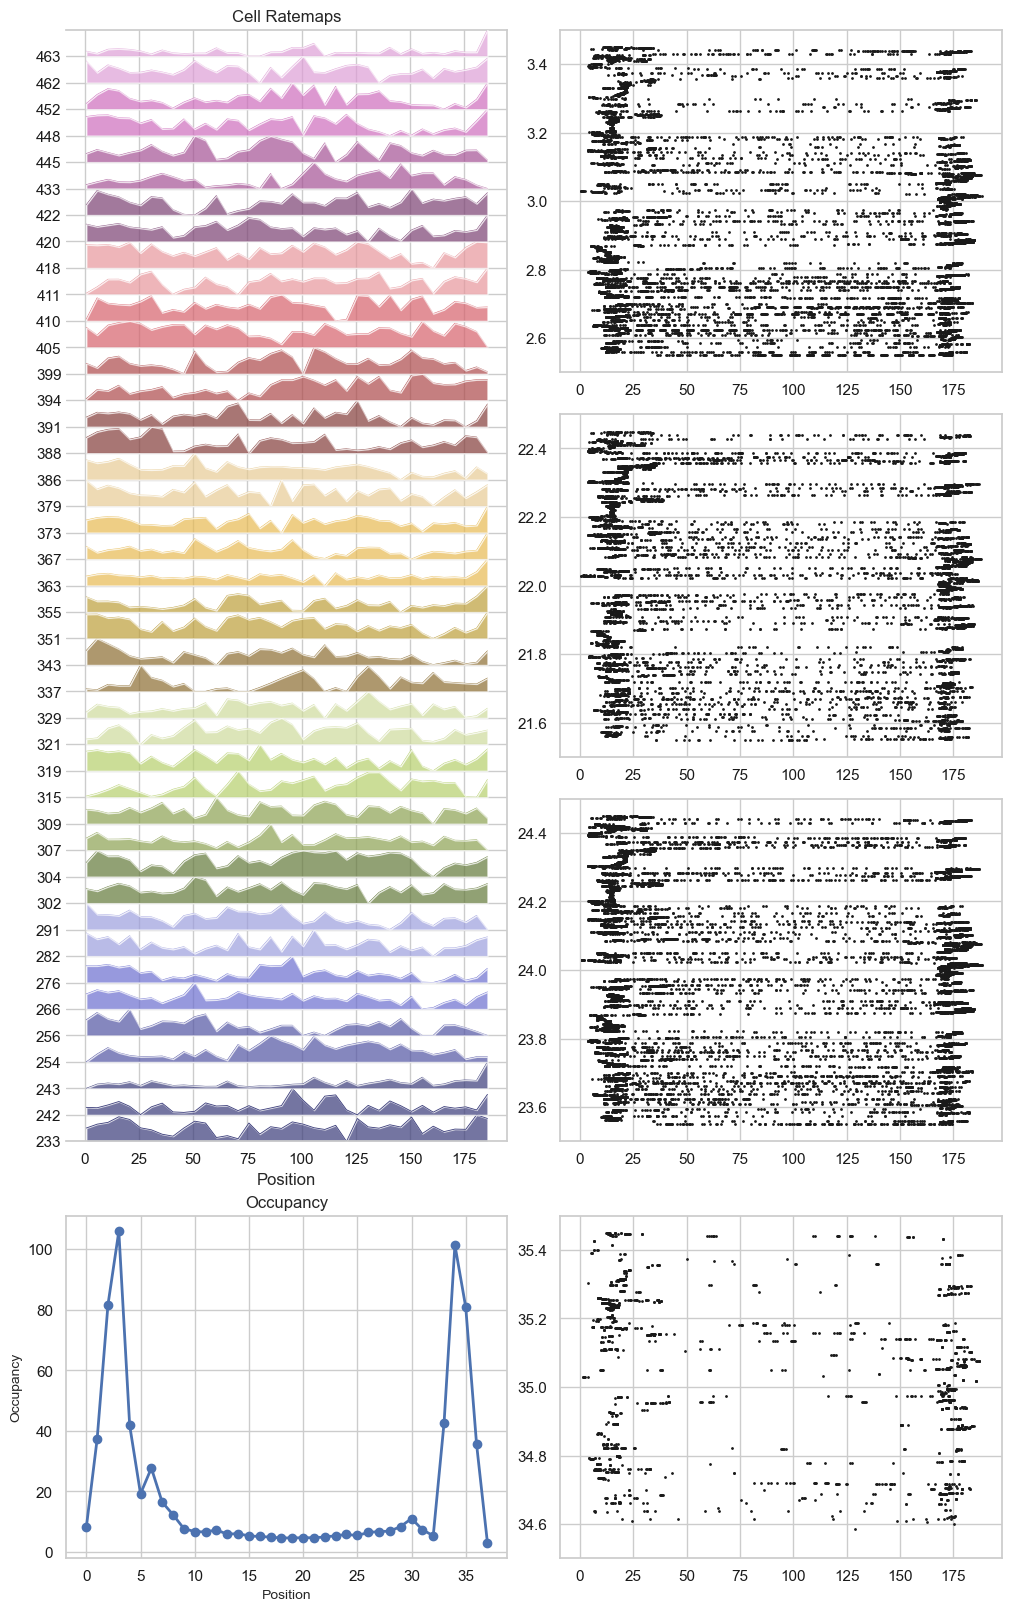

In [320]:
# Control Condition Place Fields
fig = plt.figure(figsize=(10, 16))
gs = gridspec.GridSpec(4, 2, figure=fig)

# Create an axes that spans 2 rows in the first column
ax1 = fig.add_subplot(gs[0:3, 0])  # This spans all rows in the first column
ax2 = fig.add_subplot(gs[3, 0])  # Top-right
ax3 = fig.add_subplot(gs[0, 1])  # Bottom-right
ax4 = fig.add_subplot(gs[1, 1])  # Bottom-right
ax5 = fig.add_subplot(gs[2, 1])  # Bottom-right
ax6 = fig.add_subplot(gs[3, 1])  # Bottom-right


ax1.set_title('Cell Ratemaps')
plot_ratemap(ctrl_pfs, ax=ax1, normalize_tuning_curve=True, sortby=False)

ax2.plot(ctrl_pfs.occupancy, marker='o', linestyle='-', linewidth=2)
ax2.set_title("Occupancy", fontsize=12)
ax2.set_xlabel("Position", fontsize=10)
ax2.set_ylabel("Occupancy", fontsize=10)

sns.set_theme(style="whitegrid")

ctrl_pfs.plot_ratemaps_raster(ax=ax3,plot_time=True,sort=False)
ax3.set_ylim([2.5, 3.5])

ctrl_pfs.plot_ratemaps_raster(ax=ax4,plot_time=True,sort=False)
ax4.set_ylim([21.5, 22.5])

ctrl_pfs.plot_ratemaps_raster(ax=ax5,plot_time=True,sort=False)
ax5.set_ylim([23.5, 24.5])

ctrl_pfs.plot_ratemaps_raster(ax=ax6,plot_time=True,sort=False)
ax6.set_ylim([34.5, 35.5])

Cell_0.png
Cell_1.png
Cell_2.png
Cell_3.png
Cell_4.png
Cell_5.png
Cell_6.png
Cell_7.png
Cell_8.png
Cell_9.png
Cell_10.png
Cell_11.png
Cell_12.png
Cell_13.png
Cell_14.png
Cell_15.png
Cell_16.png
Cell_17.png
Cell_18.png
Cell_19.png
Cell_20.png
Cell_21.png
Cell_22.png
Cell_23.png
Cell_24.png
Cell_25.png
Cell_26.png
Cell_27.png
Cell_28.png
Cell_29.png
Cell_30.png
Cell_31.png
Cell_32.png
Cell_33.png
Cell_34.png
Cell_35.png
Cell_36.png
Cell_37.png
Cell_38.png
Cell_39.png
Cell_40.png


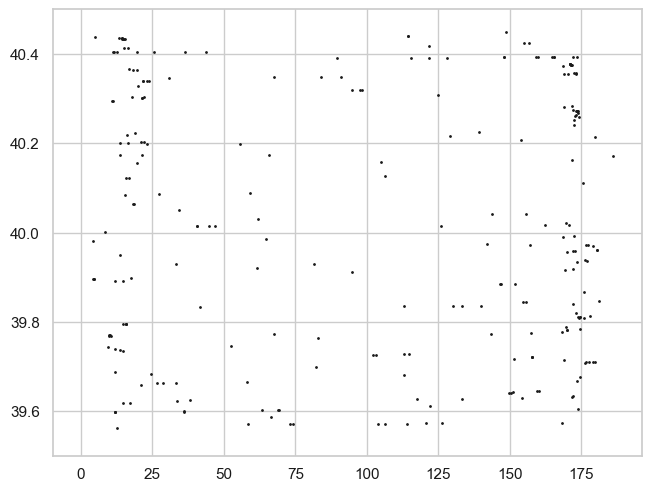

In [336]:
ax = opto_pfs.plot_ratemaps_raster(plot_time=True,sort=False)
idx = -0.5



for i in range(opto_pfs.n_neurons):
    plt.ylim([idx, idx+1])
    plot_name = f'Cell_{i}.png'
    print(plot_name)
    plt.savefig(plot_dir / plot_name, dpi=300, bbox_inches='tight')  # Save with full path
    idx =idx + 1

Ctrl_Cell_0.png
Ctrl_Cell_1.png
Ctrl_Cell_2.png
Ctrl_Cell_3.png
Ctrl_Cell_4.png
Ctrl_Cell_5.png
Ctrl_Cell_6.png
Ctrl_Cell_7.png
Ctrl_Cell_8.png
Ctrl_Cell_9.png
Ctrl_Cell_10.png
Ctrl_Cell_11.png
Ctrl_Cell_12.png
Ctrl_Cell_13.png
Ctrl_Cell_14.png
Ctrl_Cell_15.png
Ctrl_Cell_16.png
Ctrl_Cell_17.png
Ctrl_Cell_18.png
Ctrl_Cell_19.png
Ctrl_Cell_20.png
Ctrl_Cell_21.png
Ctrl_Cell_22.png
Ctrl_Cell_23.png
Ctrl_Cell_24.png
Ctrl_Cell_25.png
Ctrl_Cell_26.png
Ctrl_Cell_27.png
Ctrl_Cell_28.png
Ctrl_Cell_29.png
Ctrl_Cell_30.png
Ctrl_Cell_31.png
Ctrl_Cell_32.png
Ctrl_Cell_33.png
Ctrl_Cell_34.png
Ctrl_Cell_35.png
Ctrl_Cell_36.png
Ctrl_Cell_37.png
Ctrl_Cell_38.png
Ctrl_Cell_39.png
Ctrl_Cell_40.png


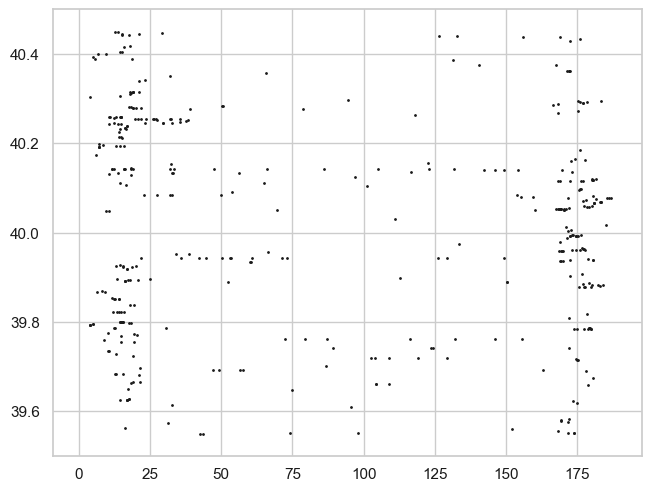

In [337]:
ax = ctrl_pfs.plot_ratemaps_raster(plot_time=True,sort=False)
idx = -0.5



for i in range(opto_pfs.n_neurons):
    plt.ylim([idx, idx+1])
    plot_name = f'Ctrl_Cell_{i}.png'
    print(plot_name)
    plt.savefig(plot_dir / plot_name, dpi=300, bbox_inches='tight')  # Save with full path
    idx =idx + 1